In [13]:
import pandas as pd
import numpy as np
import data_loader as dl
import matplotlib.pyplot as plt
import statistics as st
import seaborn as sns

In [2]:
def format_oxidation(row, column, to_replace):
    peptide = row[column]
#     print(to_replace)
    replace_with = "+15.995"
    if pd.isna(peptide):
        new_pep = peptide
    else:
        if to_replace in peptide:
            new_pep = peptide.replace(to_replace, replace_with)
        else:
            new_pep = peptide
    return new_pep

def format_carbamidomethyl(row, column, to_replace):
    peptide = row[column]
#     print(to_replace)
    replace_with = ""
    if pd.isna(peptide):
        new_pep = peptide
    else:
        if to_replace in peptide:
            new_pep = peptide.replace(to_replace, replace_with)
        else:
            new_pep = peptide
    return new_pep


In [3]:
def clean_MM(input_file):
    data = pd.read_csv(input_file, sep = '\t')

    #make a new col that includes modifide peptides
    data['temp_peptide'] = data.apply(lambda row: format_oxidation(row, "Full Sequence", "[Common Variable:Oxidation on M]"), axis=1)
    data["temp2"] = data.apply(lambda row: format_carbamidomethyl(row, "temp_peptide", "[Common Fixed:Carbamidomethyl on C]"), axis=1)

    data = data.replace({"Decoy": {'Y': True, 'N': False}})
    #uniform naming
    data_new = data.rename({"Decoy": "decoy", "Scan Number": "scan", "temp2": "peptide", 'PEP_QValue': 'probability'}, axis=1)
    data_new = data_new.filter((['decoy', 'scan', 'peptide','probability', 
                                 "Matched Ion Series", 'Matched Ion Intensities', 'Matched Ion Counts', 'Matched Ion Mass Diff (Ppm)']))

    return data_new


In [4]:
def filter_data(df):
    df = df[df["decoy"]==False]
    df = df.sort_values("probability")
    df = df.drop_duplicates(subset=["scan"], keep="first") #keep highest scoring
    df = df.sort_values("probability")
    df = df.drop_duplicates(subset=["peptide"], keep="first")#I only want unique peptides (we should double check this. I just don't know how to deal with duplicate peptides)
    df = df[df["probability"] <= .01]
    return df

In [5]:
small = clean_MM("~/Payne/bulk_data_vs_2ng/Ex_Auto_DrM3_30umT4_2ngQC_60m_half_PSMs.psmtsv.gz")
large = clean_MM("~/Payne/bulk_data_vs_2ng/metamorpheus_output/AllPSMs2.psmtsv")

small = filter_data(small)
large = filter_data(large)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (11,19,20,21,22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
#how many match?
pep_in_both = list(set(small["peptide"]).intersection(set(large["peptide"])))
len(pep_in_both)

5555

In [7]:
small = small.loc[small['peptide'].isin(pep_in_both)]
large = large.loc[large['peptide'].isin(pep_in_both)]

In [8]:
def count_Y(row):
    count = row['Matched Ion Series'].count("y")
    return(count)

def count_B(row):
    count = row['Matched Ion Series'].count("b")
    return(count)

In [9]:
#count y and b peaks
small["b_peaks"] = small.apply(count_B, axis=1)
small["y_peaks"] = small.apply(count_Y, axis=1)
small["y_peaks"] = small.apply(count_Y, axis=1)

#count y and b peaks
large["b_peaks"] = large.apply(count_B, axis=1)
large["y_peaks"] = large.apply(count_Y, axis=1)


In [10]:
#for each protein count number of peaks for bulk and single cell, and get the difference

#give them the same index (index by peptide name)
new_small = small.set_index("peptide")
new_large = large.set_index("peptide")
both = pd.merge(left=new_small, right=new_large,suffixes=('_small', '_large'), left_index=True, right_index=True, how="outer")
# # small["Matched Ion Counts"]- large["Matched Ion Counts"]
both["diff_total"] = both["Matched Ion Counts_small"] - both["Matched Ion Counts_large"]
both["diff_y"] = both["y_peaks_small"] - both["y_peaks_large"]
both["diff_b"] = both["b_peaks_small"] - both["b_peaks_large"]
####
#0 mean that they have the same number of peaks
# positive means that sc spectrum had more peaks
# negative means that bulk had more peaks

In [14]:
both[["y_peaks_small", "y_peaks_large", "b_peaks_large", "b_peaks_small"]].head(20)

,y_peaks_small,y_peaks_large,b_peaks_large,b_peaks_small
peptide,,,,
AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,2,11,10
AAAAAAALQAK,10,7,5,5
AAAAADLANR,7,5,3,3
AAAEVNQDYGLDPK,9,9,3,4
AAAFEQLQK,7,7,2,2
AAAIGIDLGTTYSCVGVFQHGK,12,8,1,3
AAALEFLNR,8,6,2,2
AAAPAPEEEMDECEQALAAEPK,12,16,3,9
AAAPAPVSEAVCR,7,10,4,4


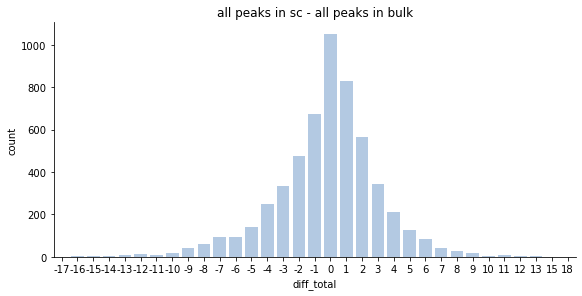

In [15]:
plot = sns.catplot(x="diff_total", color= '#abc9ea', hue=None,
                data=both, kind="count",
                height=4, aspect=2).set(title='all peaks in sc - all peaks in bulk')

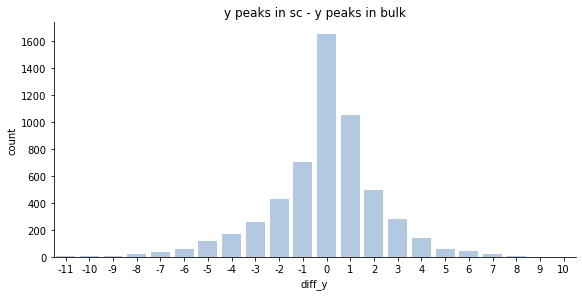

In [16]:
plot = sns.catplot(x="diff_y", color= '#abc9ea', hue=None,
                data=both, kind="count",
                height=4, aspect=2).set(title="y peaks in sc - y peaks in bulk")

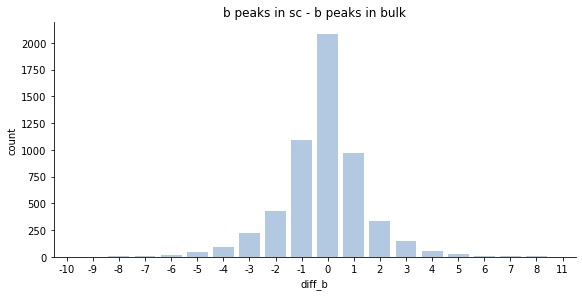

In [17]:
plot = sns.catplot(x="diff_b", color= '#abc9ea', hue=None,
                data=both, kind="count",
                height=4, aspect=2).set(title="b peaks in sc - b peaks in bulk")

In [18]:
import numbers
def get_intensities(row, small):
    intensities = []
    if small == True:
        line = row["Matched Ion Intensities_small"].split(";")
    else:
        line = row["Matched Ion Intensities_large"].split(";")
    for el in line:
        el = el.strip('][').split(",")
        for sub_el in el:
            sub_el = sub_el.split(":")[1]
            intensities.append(sub_el)
    return intensities

both["intensity_small"] = both.apply(lambda row: get_intensities(row, small=True), axis=1)
both["intensity_large"] = both.apply(lambda row: get_intensities(row, small=False), axis=1)

In [19]:
#get top 3 intensities
def get_top3(row, size, top):
    row['intensity_'+size].sort(key=int, reverse=True)
    if top==True:
        return3 = row['intensity_'+size][:3]
        return3 = [float(i) for i in return3]
    else:
        return3 = row['intensity_'+size][-3:]
        return3 = [float(i) for i in return3]
        
    return return3


both["top3_small"] = both.apply(lambda row: get_top3(row, size="small", top=True), axis=1)
both["bottom3_small"] = both.apply(lambda row: get_top3(row, size='small', top=False), axis=1)
both["top3_large"] = both.apply(lambda row: get_top3(row, size="large", top=True), axis=1)
both["bottom3_large"] = both.apply(lambda row: get_top3(row, size='large', top=False), axis=1)


In [20]:
def get_intensity_diff(row, size):
    intensity_diff = st.mean(row["top3_"+size])/st.mean(row["bottom3_"+size])
    return intensity_diff

both['intensity_diff_small'] = both.apply(lambda row: get_intensity_diff(row, size="small"), axis=1)
both['intensity_diff_large'] = both.apply(lambda row: get_intensity_diff(row, size="large"), axis=1)


(-10.0, 50.0)

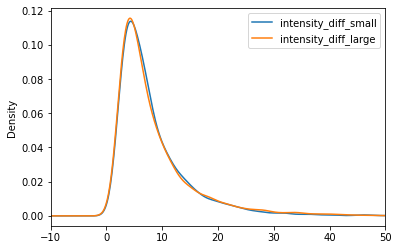

In [34]:
both_plot = both[["intensity_diff_small", "intensity_diff_large"]]
ax = both_plot.plot.kde()
ax.set_xlim(-10, 50)

In [22]:
def count_len(row):
    length = len(row["peptide"])
    return length

small["len"]= small.apply(lambda row: count_len(row), axis=1)
small_7to14 = small[(small['len'] >=7) & (small['len'] <=14)]
small_14to21 = small[(small['len'] >14) & (small['len'] <=21)]
small_21to44 = small[(small['len'] >21) & (small['len'] <=44)]

large["len"]= large.apply(lambda row: count_len(row), axis=1)
large_7to14 = large[(large['len'] >=7) & (large['len'] <=14)]
large_14to21 = large[(large['len'] >14) & (large['len'] <=21)]
large_21to44 = large[(large['len'] >21) & (large['len'] <=44)]

In [ ]:
plot = sns.catplot(x="diff_b", color= '#abc9ea', hue=None,
                data=both, kind="count",
                height=4, aspect=2).set(title="b peaks in sc - b peaks in bulk")

In [42]:
x

0        14
8455      4
8450      2
9031      3
10225     5
         ..
10954     1
18272     1
6810      2
14450     5
18209     1
Name: b_peaks, Length: 5555, dtype: int64

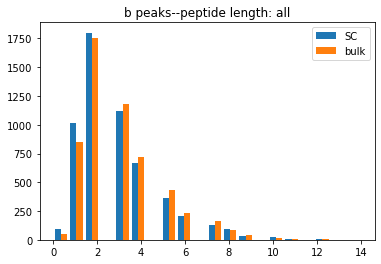

In [44]:
x = small["b_peaks"]
y = large["b_peaks"]
plt.hist([x, y], bins = 20)
plt.legend(['SC', 'bulk'])
plt.title("b peaks--peptide length: all")

plt.show()

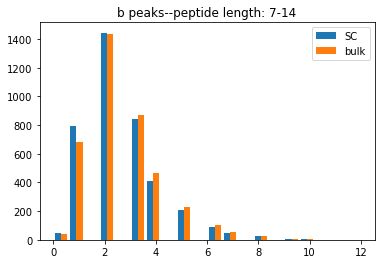

In [24]:
x = small_7to14["b_peaks"]
y = large_7to14["b_peaks"]
plt.hist([x, y], bins = 20)
plt.legend(['SC', 'bulk'])
plt.title("b peaks--peptide length: 7-14")
plt.show()

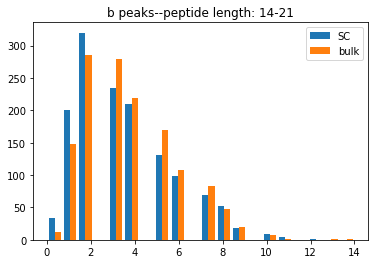

In [25]:
x = small_14to21["b_peaks"]
y = large_14to21["b_peaks"]
plt.hist([x, y], bins = 20)
plt.legend(['SC', 'bulk'])
plt.title("b peaks--peptide length: 14-21")
plt.show()

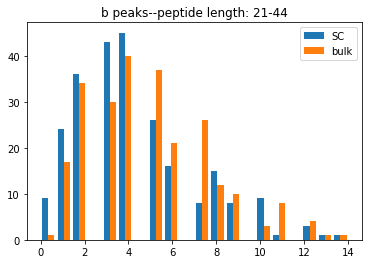

In [26]:
x = small_21to44["b_peaks"]
y = large_21to44["b_peaks"]
plt.hist([x, y], bins = 20)
plt.legend(['SC', 'bulk'])
plt.title("b peaks--peptide length: 21-44")
plt.show()

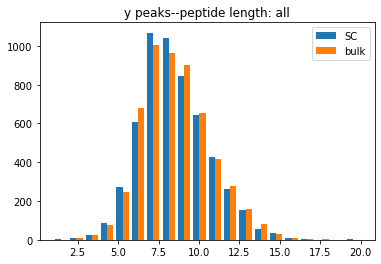

In [27]:
x = small["y_peaks"]
y = large["y_peaks"]
plt.hist([x, y], bins = 20)
plt.legend(['SC', 'bulk'])
plt.title("y peaks--peptide length: all")
plt.show()

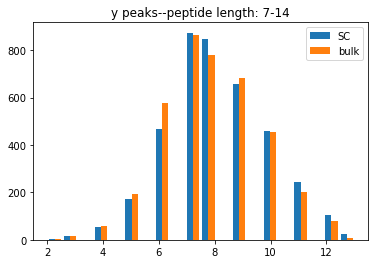

In [28]:
x = small_7to14["y_peaks"]
y = large_7to14["y_peaks"]
plt.hist([x, y], bins = 20)
plt.legend(['SC', 'bulk'])
plt.title("y peaks--peptide length: 7-14")
plt.show()

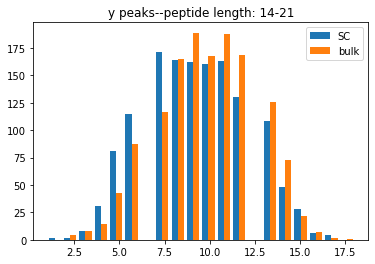

In [29]:
x = small_14to21["y_peaks"]
y = large_14to21["y_peaks"]
plt.hist([x, y], bins = 20)
plt.legend(['SC', 'bulk'])
plt.title("y peaks--peptide length: 14-21")
plt.show()

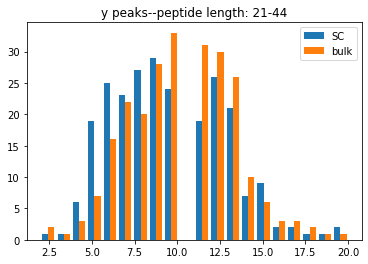

In [30]:
x = small_21to44["y_peaks"]
y = large_21to44["y_peaks"]
plt.hist([x, y], bins = 20)
plt.legend(['SC', 'bulk'])
plt.title("y peaks--peptide length: 21-44")
plt.show()

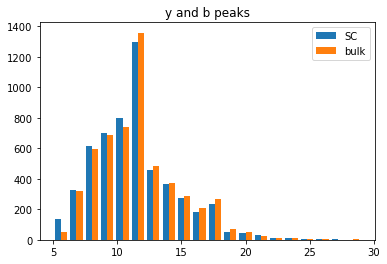

In [38]:
x = small["Matched Ion Counts"]
y = large["Matched Ion Counts"]
plt.hist([x, y], bins=20)
plt.legend(['SC', 'bulk'])
plt.title("y and b peaks")
plt.show()
